# Модель предсказания коэффициента восстановления золота из руды

Данные с параметрами добычи и очистки золота были предоставлены компанией «Цифра», где разрабатываются решения для эффективной работы промышленных предприятий.

**Задача проекта:** модель, которая поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

### Что нужно спрогнозировать:

- эффективность обогащения чернового концентрата `rougher.output.recovery`
- эффективность обогащения финального концентрата `final.output.recovery`

# Оглавление

1. Подготовка данных 
    * [1.1. Открытые и изучение файлов](#1.1)
    * [1.2. Проверка правильности эффективности обогащения](#1.2)
    * [1.3. Анализ признаков в тестовой и обучающей выборках](#1.3)    
    * [1.4. Предобработка данных](#1.4)

2. Анализ данных
    * [2.1. Анализ концентрации металлов (Au, Ag, Pb) на различных этапах очистки](#2.1)
    * [2.2. Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках](#2.2)
    * [2.3. Анализ суммарной концентрации всех веществ на разных стадиях](#2.3)


3. Построение модели
    * [3.1. Функция для вычисления итоговой sMAPE](#3.1)
    * [3.2. Выбор целевых признаков](#3.2)
    * [3.3 Выбор модели для эффективностей обогащения](#3.3)
    * [3.4 Проверка моделей на тестовой выборке](#3.4)
 
4. [Вывод](#end)

# Подключение и настройка необходимых библиотек

In [2]:
# отключение предупреждений
import warnings; warnings.filterwarnings('ignore', category=Warning)

In [3]:
# обновление seaborn
#!pip install --upgrade seaborn
# обновление sklearn
#!pip3 install --upgrade --user --quiet sklearn

# установка библиотеки imblearn
#!pip install imblearn

# если после установки imblearn ломается scikit-learn, то pip install -U scikit-learn==0.23 

# установка xgboost и catboost
# conda install -c anaconda py-xgboost
# conda install catboost и pip install catboost

In [4]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

pd.options.display.float_format = '{:.3f}'.format

In [5]:
small, medium, large = 14, 16, 22 
params = {'figure.figsize': (12, 6),
          'figure.titlesize': medium,
          'legend.fontsize':  small,
          'axes.titlesize':   small,
          'axes.labelsize':   small,
          'xtick.labelsize':  small,
          'ytick.labelsize':  small,
          'legend.loc':       'best'}
plt.rcParams.update(params)

In [6]:
# подключение библиотек машинного обучения
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import mean_absolute_error, make_scorer

from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# 1. Подготовка данных
## 1.1. Открытие и изучение файлов <a name="1.1"></a>


### Наименование признаков
`[этап].[тип_параметра].[название_параметра]`

Пример: rougher.input.feed_ag

Возможные значения для блока `[этап]`:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

'rougher.output.tail_au'
'primary_cleaner.output.tail_au'
'secondary_cleaner.output.tail_au'


эти три - это хвосты после каждого из этапов, а это итоговый хвост, суммарный если можно так сказать:

'final.output.tail_au'

In [7]:
#напишем функцю для загрузки файла, где file_path -- папка, содержащая df

def load_data(file_path, *args, **kwargs):
    """Загрузка датафрейма Pandas из локального файла file_path"""
    try:
        data = pd.read_csv(file_path, *args, **kwargs)
        print(f'Файл "{file_path}" загружен и готов к использованию')
    except FileNotFoundError:
        print('Загрузка файла через интернет')
        data = pd.read_csv('https://code.s3/'+file_path)
    return data

In [8]:
data_train = load_data('datasets/gold_recovery_train.csv', index_col='date')
data_test = load_data('datasets/gold_recovery_test.csv', index_col='date')
data_full = load_data('datasets/gold_recovery_full.csv', index_col='date')

Файл "datasets/gold_recovery_train.csv" загружен и готов к использованию
Файл "datasets/gold_recovery_test.csv" загружен и готов к использованию
Файл "datasets/gold_recovery_full.csv" загружен и готов к использованию


In [9]:
# установим индексам тип DatetimeIndex
data_test.index = pd.DatetimeIndex(data_test.index)
data_train.index = pd.DatetimeIndex(data_train.index)
data_full.index = pd.DatetimeIndex(data_full.index)

**Посмотрим на общую информацию о данных в таблицах**

Посмотрим на список признаков в нем и пропущенные значения

In [10]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au                     

In [11]:
print(data_train.shape)
print(data_test.shape)

(16860, 86)
(5856, 52)


Полный набор данных включает 86 признаков, которые описывают этапы, различные параметры продуктов на каждом этапе и финальные характеристики. Тренировочный сет состоит также из 86 признаков, а вот тестовый  имеет лишь 52, разберемся поподробнее  и выясним, как лучше сравнять количество: добавлением признаков к тестовому или удалением из обучающего. Но сначала разберемся с эффективностью обогащения

## 1.2. Проверка правильности эффективности обогащения <a name="1.2"></a>

Нужно проверить, что эффективность обогащения рассчитана правильно. Вычислить её на обучающей выборке для признака `rougher.output.recovery`. Найти MAE между расчётами и значением признака. Описать выводы.

**Эффективность обогащения** рассчитывается по формуле: **C*(F-T) / F*(C-T)**, где
- C — доля золота в концентрате после флотации/очистки (`rougher.output.concentrate_au`)
- F — доля золота в сырье/концентрате до флотации/очистки (`rougher.input.feed_au`)
- T — доля золота в отвальных хвостах после флотации/очистки (`rougher.output.tail_au`)

In [12]:
# Напишем функцию для подсчета эффективности обогащения
def rougher_recovery(data):
    C = data['rougher.output.concentrate_au'] # доля золота в концентрате после флотации
    F = data['rougher.input.feed_au'] # доля золота в сырье до флотации
    T = data['rougher.output.tail_au'] # доля золота в отвальных хвостах после флотации
    recovery = (C*(F-T)) / (F*(C-T))
    return recovery * 100

In [13]:
# на этапе проверки не будем заполнять значения, чтобы избежать ошибок
# выделим данные в отдельных датасет без пропусков
data_recovery = data_train[['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']].dropna()

In [14]:
data_recovery['count_rougher_recovery'] = rougher_recovery(data_recovery)

In [15]:
# найдем среднее абсолютное отклонение
mean_absolute_error(data_recovery['rougher.output.recovery'], data_recovery['count_rougher_recovery'])

9.444891926100695e-15

Для удобства интерпритации напишем функцию, которая определяет МАЕ в процентах

In [16]:
def mean_absolute_percentage_error(value_true, value_pred): 
    return np.mean(np.abs((value_true - value_pred) / value_true)) * 100

In [17]:
mean_absolute_percentage_error(data_recovery['rougher.output.recovery'], data_recovery['count_rougher_recovery'])

1.186527731137691e-14

Итак, в среднем реальные значения отличаются от высчитанных вручную на 1.2% (примерно на 9 единиц)

## 1.3. Анализ признаков в тестовой и обучающей выборках <a name="1.3"></a>

In [18]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                     

Обучающий сет данных содержит 86 признаков, которые включают в себя:
- `final.output` -- финальные характеристики концентратов разных металлов
- `primary_cleaner.input` -- параметры сырья на первичном этапе обработки
- `primary_cleaner.output` -- параметры продукта на первичном этапе обработки
- `primary_cleaner.state` -- параметры, характеризующие текущее состояние первичного этапа
- `rougher.calculation` -- расчетные характеристики флотации 
- `rougher.input` -- параметры сырья флотации
- `rougher.output` -- параметры продукта флотации
- `rougher.state` -- параметры, характеризующие состояние флотации
- `secondary_cleaner.output` -- параметры продукта на втором этапе очистки
- `secondary_cleaner.state` -- параметры продукта на втором этапе очистки
- целевые признаки `rougher.output.recovery` и `final.output.recovery` 

In [19]:
# Посмотрим еще раз, сколько признаков находятся в тестовом
data_test.shape[1]

52

Их уже 52, значит 34 признака отсутствуют в тестовом наборе. Посмотрим на них подробнее

In [20]:
# выделим те столбцы, которые присутсвуют только в обучающем сете
columns_train_only = set(data_train.columns) - set(data_test.columns)

In [21]:
# выделим в df и отсортируем столбцы для удобства восприятия
data_columns_train_only = data_train[columns_train_only]
data_columns_train_only.reindex(sorted(data_columns_train_only.columns), axis=1).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_au                         16789 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_au                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                    

Что имеем: в тестовой выборке отсутствуют параметры и расчетные характеристики продукта на разных этапах очистки (output иcalculation). Показатели замеряются и/или рассчитываются значительно позже, поэтому модель не будет получать их в будущем на входе. Целесобразно их удалить (плюс удалить целевые признаки, выделив их отдельно). 

Основываясь на логике, что нам нужно отобрать только те данные, которые модель может получить на вход в самом начале, проанализируем данные в тестовой/тренировочной выборке и решим, какие из них дейтвительно нужны для построения модели, а какие можем смело удалить.

Для этого взглянем подробнее на технологический процесс. Нас интересует именно вводные параметры флотации, ведь именно на них мы можем повлиять и только их модель будет получать в дальнейшем на входе 

**Технологический процесс:**

- *Rougher feed* — исходное сырье
- *Rougher additions (или reagent additions)* — флотационные реагенты: Xanthate, Sulphate, Depressant
- *Xanthate* -— ксантогенат (промотер, или активатор флотации);
- *Sulphate* — сульфат (на данном производстве сульфид натрия);
- *Depressant* — депрессант (силикат натрия)
- *Rougher process* (англ. «грубый процесс») — флотация
- *Rougher tails* — отвальные хвосты
- *Float banks* — флотационная установка
- *Cleaner process* — очистка
- *Rougher Au* — черновой концентрат золота
- *Final Au* — финальный концентрат золота

**Параметры этапов:**
- *air amount* — объём воздуха
- *fluid levels* — уровень жидкости
- *feed size* — размер гранул сырья
- *feed rate* — скорость подачи

In [22]:
data_test.columns

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

В тестовом сете присуствуют все признаки, на которые мы можем влиять в процессе (это вводные данные сырья для флотации и параметры, характеризующие текущее состояние различных этапов: уровень воздуха, жидкости, размер гранул и скорость подачи), добавим целевые признаки из data_full, которые отсутствуют, ведь на них мы будем проверять модель

In [23]:
# удалим столбцы из обучающего сета
data_train = data_train.drop(columns_train_only, axis=1)

## 1.4. Предобработка данных <a name="1.4"></a>

In [24]:
# Посмотрим на количество пропущенных значений в выборках
data_train.isna().sum()

primary_cleaner.input.sulfate                 1307
primary_cleaner.input.depressant              1262
primary_cleaner.input.feed_size                  0
primary_cleaner.input.xanthate                 985
primary_cleaner.state.floatbank8_a_air          40
primary_cleaner.state.floatbank8_a_level        33
primary_cleaner.state.floatbank8_b_air          40
primary_cleaner.state.floatbank8_b_level        27
primary_cleaner.state.floatbank8_c_air          38
primary_cleaner.state.floatbank8_c_level        27
primary_cleaner.state.floatbank8_d_air          39
primary_cleaner.state.floatbank8_d_level        27
rougher.input.feed_ag                           82
rougher.input.feed_pb                          228
rougher.input.feed_rate                        513
rougher.input.feed_size                        417
rougher.input.feed_sol                         292
rougher.input.feed_au                           83
rougher.input.floatbank10_sulfate             1044
rougher.input.floatbank10_xanth

In [25]:
data_test.isna().sum()

primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257
rougher.input.floatbank10_xanthate            123


Пропусков не много, но зато они есть в каждом столбце. Но так как соседние по времени параметры часто похожи, заполним их методом interpolate

In [26]:
data_test = data_test.interpolate(method='time', axis=0, limit=None, inplace=False, limit_direction='both', downcast=None)
data_train = data_train.interpolate(method='time', axis=0, limit=None, inplace=False, limit_direction='both', downcast=None)

Пропущенных значений больше нет! Пора приступить к анализу данных

# 2. Анализ данных

## 2.1. Анализ концентрации металлов (Au, Ag, Pb) на различных этапах очистки <a name="2.1"></a>

Будем анализировать данные из полной таблицы. Чтобы не додумывать и не испортить результаты, будем работать с таблицей без пропусков. Для удобства выделим отдельно концентрации металлов на каждом этапе

In [27]:
analyze_full = data_full.dropna()

In [28]:
# посмотрим на концентрацию золота
au_concentrates = [col for col in data_full if 'concentrate_au' in col]

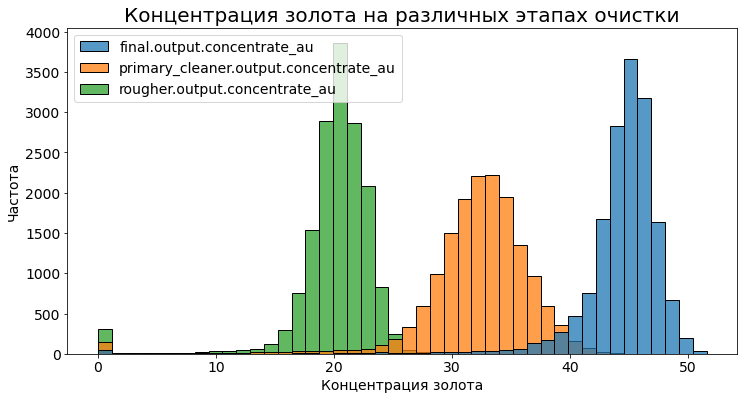

In [29]:
sns.histplot(data=analyze_full[au_concentrates])
plt.xlabel('Концентрация золота') 
plt.ylabel('Частота') 
plt.title('Концентрация золота на различных этапах очистки', fontsize=20);

Заметили следующее: 

Во-первых, видим нулевые выбросы. Скорее всего, это ошибка в данных, ведь если мы загружаем первичную смесь золотосодержащей руды, в которой самого золота нет, значит даже нет необходимости проводить над ней манипуляции по очистке, золота нет

Во-вторых, концентрация золота увеличивается по мере прохождения этапов очистки: так после флотации с среднем концентрация золота около 20, тогда как в конце это число увеличивается до 40-50


Удалим выбросы в сырье в тестовых и обучающих данных

In [30]:
data_test = data_test[data_test['rougher.input.feed_au'] != 0]
data_train = data_train[data_train['rougher.input.feed_au'] != 0]

Теперь взглянем на концентрацию серебра и свинца на различных этапах

In [31]:
# выделим их отдельно от золота
ag_pb_concentrates = [col for col in data_full for string in ('concentrate_ag', 'concentrate_pb') if string in col]

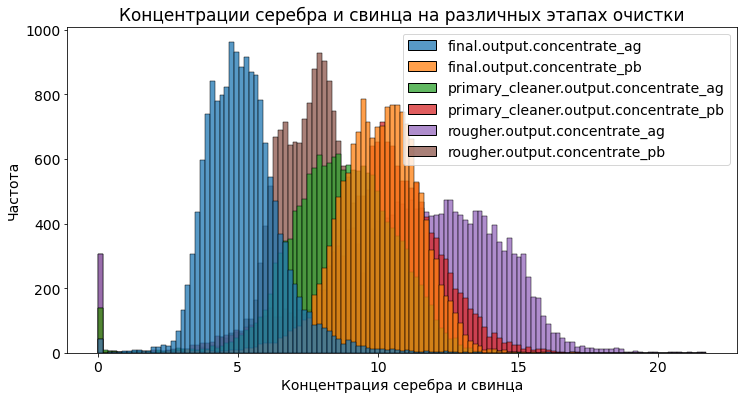

In [32]:
sns.histplot(data=analyze_full[ag_pb_concentrates])
plt.xlabel('Концентрация серебра и свинца') 
plt.ylabel('Частота') 
plt.title('Концентрации серебра и свинца на различных этапах очистки', fontsize=17);

Здесь интереснее, помимо того, что также присутствуют выбросы с нулевым значением, концентрация этих металлов отличается. 

Так концентрация серебра после флотации в среднем в три раза выше, чем на финальном этапе очистки. 

Концентрация свинца же наоборот, максимальна после флотации, увеличивается после первичной очистки и после второго этапа остается на том же уровне

**Вывод:** после каждого этапа очистки концентрация золота увеличивается (причем равномерно после первой и второй очистки). Концентрация серебра уменьшается по мере этапов очистки, а концентрация свинца увеличивается после флотации, затем после первого этапа очистки и после второго не меняется.

## 2.2. Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках <a name="2.2"></a>

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной

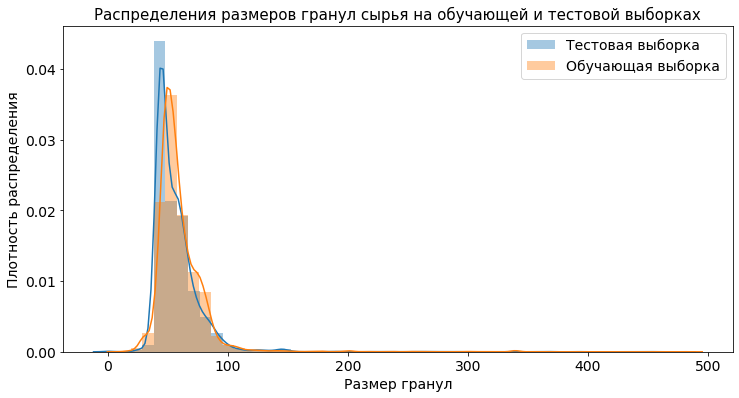

In [33]:
fig, ax = plt.subplots()
sns.distplot(data_test['rougher.input.feed_size'], ax=ax, label='Тестовая выборка')
sns.distplot(data_train['rougher.input.feed_size'], ax=ax, label='Обучающая выборка')
plt.xlabel('Размер гранул') 
plt.ylabel('Плотность распределения') 
plt.title('Распределения размеров гранул сырья на обучающей и тестовой выборках', fontsize=15)
plt.legend();

**Вывод:** распределения в выборках не сильно отличаются друг от друга, можем смело использовать

## 2.3. Анализ суммарной концентрации всех веществ на разных стадиях <a name="2.3"></a>

Посмотрим на суммарные концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [34]:
input_concentrate = ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au']

In [35]:
analyze_full['final_sum_concentrate'] = analyze_full.loc[:,'final.output.concentrate_ag':'final.output.concentrate_au'].sum(axis=1)
analyze_full['input_sum_concentrate'] = analyze_full.loc[:,input_concentrate].sum(axis=1)
analyze_full['rougher_sum_concentrate'] = analyze_full.loc[:,'rougher.output.concentrate_ag':'rougher.output.concentrate_au'].sum(axis=1)

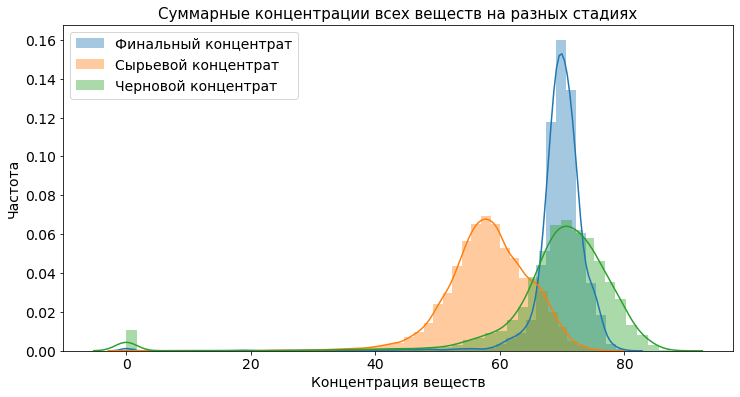

In [36]:
fig, ax = plt.subplots()
sns.distplot(analyze_full['final_sum_concentrate'], ax=ax, label='Финальный концентрат')
sns.distplot(analyze_full['input_sum_concentrate'], ax=ax, label='Сырьевой концентрат')
sns.distplot(analyze_full['rougher_sum_concentrate'], ax=ax, label='Черновой концентрат')
plt.xlabel('Концентрация веществ') 
plt.ylabel('Частота') 
plt.title('Суммарные концентрации всех веществ на разных стадиях', fontsize=15)
plt.legend();

**Вывод:** суммарная концентрация веществ на всех этапах распределена равномерно. В сырьевом концентрация меньше всего: думаю, это связано с тем, что после очистки увеличивается концентрация золота в сырье. В распределении также присутствуют выбросы, которые мы удалим из тестовой и тренировочной сетов

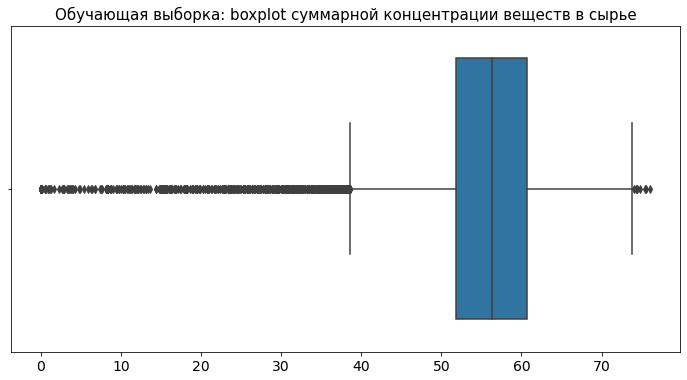

In [37]:
# Посмотрим подробнее на выбросы в обучающей выборке
sns.boxplot(data_train.loc[:,input_concentrate].sum(axis=1))
plt.title('Обучающая выборка: boxplot суммарной концентрации веществ в сырье', fontsize=15);

In [38]:
data_train['input_sum_concentrate'] = data_train.loc[:,input_concentrate].sum(axis=1)

In [39]:
# напишем функцию для удаления выбросов
def drop_anomalies(data,col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    data = data[(data[col] > (Q1-3*IQR)) & (data[col] < (Q3+3*IQR))]
    return data


In [40]:
drop_anomalies(data_train, 'input_sum_concentrate')
del data_train['input_sum_concentrate']

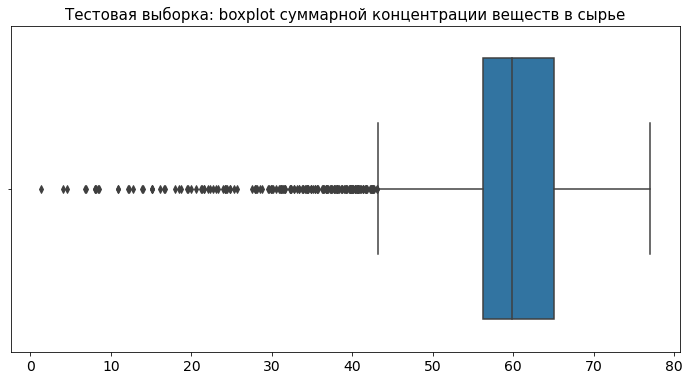

In [40]:
# теперь взглянем на выбросы в тестовой выборке
sns.boxplot(data_test.loc[:,input_concentrate].sum(axis=1))
plt.title('Тестовая выборка: boxplot суммарной концентрации веществ в сырье', fontsize=15);

In [41]:
# повторим с обучающим сетом и удалим выбросы
data_test['input_sum_concentrate'] = data_test.loc[:,input_concentrate].sum(axis=1)

drop_anomalies(data_test, 'input_sum_concentrate')
del data_test['input_sum_concentrate']

# 3. Построение модели
## 3.1. Функция для вычисления итоговой sMAPE <a name="3.1"></a>

In [42]:
def check_smape_rough(target_rough, pred_rough):
    smape_rough = 25/len(pred_rough) * np.sum(2 * np.abs(target_rough - pred_rough) / (np.abs(target_rough) + np.abs(pred_rough)))
    return smape_rough

def check_smape_final(target_final, pred_final):
    smape_final = 75/len(pred_final) * np.sum(2 * np.abs(target_final - pred_final) / (np.abs(target_final) + np.abs(pred_final)))
    return smape_final


In [43]:
scorer_rough = make_scorer(check_smape_rough)
scorer_final = make_scorer(check_smape_final)

## 3.2. Выбор целевых признаков <a name="3.2"></a>

**Целевые признаки:**
- эффективность обогащения чернового концентрата `rougher.output.recovery`
- эффективность обогащения финального концентрата `final.output.recovery`

Обоих целевых признаков нет как в обучающей, так и в тестовой выборках. Зато они есть в полном сете, откуда мы их и подтянем

In [44]:
rougher_target = data_full['rougher.output.recovery']
final_target = data_full['final.output.recovery']

In [45]:
# присоединим целевые признаки к выборкам
data_test = data_test.join([rougher_target, final_target])

In [46]:
data_train = data_train.join([rougher_target, final_target])

In [47]:
print('Тестовая выборка: пропуски в черновом концентрате', data_test['rougher.output.recovery'].isna().sum())
print('Тестовая выборка: пропуски в финальном концентрате', data_test['final.output.recovery'].isna().sum())

Тестовая выборка: пропуски в черновом концентрате 140
Тестовая выборка: пропуски в финальном концентрате 42


In [48]:
print('Обучающая выборка: пропуски в черновом концентрате', data_train['rougher.output.recovery'].isna().sum())
print('Обучающая выборка: пропуски в финальном концентрате', data_train['final.output.recovery'].isna().sum())

Обучающая выборка: пропуски в черновом концентрате 862
Обучающая выборка: пропуски в финальном концентрате 176


In [49]:
# удалим пропуски в целевых значениях в обучающем сете, в тестовом не будем, так как
data_train = data_train.dropna()
data_test = data_test.dropna()

Выделим признаки и таргет отдельно. Так как нам нужно предсказать два показателя: эффективность обогащения **чернового концентрата** и эффективность обогащения **финального концентрата**, то логично сделать два отдельных набора признаков для предсказания. 

По части мы будем предсказывать `rougher.output.recovery`, ведь она зависит исключительно от вводных данных (остальные открываются только после флотации)

Второй показатель `final.output.recovery` уже зависит от большего количества вводных данных, которые к тому же могут меняться и после флотации. Выделим их отдельно

In [50]:
feature_train_rougher = data_train.loc[:, 'rougher.input.feed_ag':'rougher.state.floatbank10_f_level']
target_train_rougher = data_train['rougher.output.recovery']

feature_train_final = data_train.loc[:, 'primary_cleaner.input.sulfate':'secondary_cleaner.state.floatbank6_a_level']
target_train_final = data_train['final.output.recovery']

In [51]:
feature_test_rougher = data_test.loc[:, 'rougher.input.feed_ag':'rougher.state.floatbank10_f_level']
target_test_rougher = data_test['rougher.output.recovery']

feature_test_final = data_test.loc[:, 'primary_cleaner.input.sulfate':'secondary_cleaner.state.floatbank6_a_level']
target_test_final = data_test['final.output.recovery']

Теперь, когда мы имеем 2 разных набора признаков для каждого показателя эффективности обогащения, приведем их к одному масштабу и приступим к выбору предсказательной модели

In [52]:
# Приведем числовые признаки к одному масштабу
scaler_rougher = StandardScaler().fit(feature_train_rougher)
scaler_final = StandardScaler().fit(feature_train_final)

# преобразуем данные 
feature_train_rougher = scaler_rougher.transform(feature_train_rougher)
feature_test_rougher = scaler_rougher.transform(feature_test_rougher)

feature_train_final = scaler_final.transform(feature_train_final)
feature_test_final = scaler_final.transform(feature_test_final)

## 3.3 Выбор модели для эффективностей обогащения <a name="3.3"></a>

### Baseline модель

Перед тем, как приступить к обучению моделей и подбору подходящих параметров, создадим простейшую модель, которая всегда предсказывает среднее значение. Так мы сможем сравнить результаты нашей будущей модели с результатами dummy модели, которая выдает только один вариант

In [53]:
# random_state для всех моделей на будущее
rs = 12

In [54]:
dummy_regr_rougher = DummyRegressor(strategy="mean")

dummy_regr_rougher.fit(feature_train_rougher, target_train_rougher)

DummyRegressor()

In [80]:
dummy_regr_final = DummyRegressor(strategy="mean")

dummy_regr_final.fit(feature_train_final, target_train_final)

DummyRegressor()

In [55]:
np.mean(cross_val_score(
    dummy_regr_rougher, 
    feature_train_rougher, 
    target_train_rougher, 
    scoring=make_scorer(check_smape_rough), 
    cv=5, 
    n_jobs=-1)
)

3.024028445136307

Итак, наша дамми-модель  выдает далеко не лучшие результаты, предсказывая все время среднее значение. Посмотрим на результаты осмысленных моделей

### Линейная регрессия

In [56]:
regressor_rougher = LinearRegression()
regressor_rougher.fit(feature_train_rougher, target_train_rougher)

LinearRegression()

In [57]:
np.mean(
    cross_val_score(
    regressor_rougher, 
    feature_train_rougher, 
    target_train_rougher, 
    scoring=make_scorer(check_smape_rough), 
    cv=5, 
    n_jobs=-1)
)

3.0564619453964186

Линейная регрессия здесь явно не фаворит гонки, она ненамного превзошла дамми-модель 

### Случайный лес

In [58]:
rf_rough = RandomForestRegressor(random_state=rs)

In [59]:
rf_rough.fit(feature_train_rougher, target_train_rougher)

RandomForestRegressor(random_state=12)

In [60]:
np.mean(
    cross_val_score(
    rf_rough, 
    feature_train_rougher, 
    target_train_rougher, 
    scoring=make_scorer(check_smape_rough), 
    cv=5, 
    n_jobs=-1)
)

3.432824849541878

Ладно, случайный лес с параметрами по умолчанию, все-таки ты справился лучше, чем линейная регрессия. Проверим его результаты на эффективности обогащения финального концентрата

In [61]:
rf_final = RandomForestRegressor(random_state=rs)

In [62]:
rf_final.fit(feature_train_final, target_train_final)

RandomForestRegressor(random_state=12)

In [63]:
np.mean(
    cross_val_score(
    rf_final, 
    feature_train_final, 
    target_train_final, 
    scoring=scorer_final, 
    cv=5, 
    n_jobs=-1)
)

8.396183668843252

Итог: в сумме эти две метрики должны дать нам довольно неплохую итоговую sMAPE, но мы еще проверим в деле градиентный бустинг

### Градиентный бустинг

In [64]:
%%time
gb_rough = GradientBoostingRegressor(random_state=rs)
gb_rough.fit(feature_train_rougher, target_train_rougher)

CPU times: user 12.7 s, sys: 39.7 ms, total: 12.8 s
Wall time: 12.8 s


GradientBoostingRegressor(random_state=12)

In [65]:
np.mean(
    cross_val_score(
    gb_rough, 
    feature_train_rougher, 
    target_train_rougher, 
    scoring=scorer_rough, 
    cv=5, 
    n_jobs=-1)
)

3.1468947918027417

In [66]:
# Настроим показатели для модели: количество деревьев (n_estimators) и максимальную глубину (max_depth)
best_gbm = GradientBoostingRegressor(n_estimators=70, max_depth=8, random_state=rs)
best_gbm.fit(feature_train_rougher, target_train_rougher)

GradientBoostingRegressor(max_depth=8, n_estimators=70, random_state=12)

In [67]:
np.mean(
    cross_val_score(
    best_gbm, 
    feature_train_rougher, 
    target_train_rougher, 
    scoring=scorer_rough, 
    cv=5, 
    n_jobs=-1)
)

3.5824055504997765

Проверим результаты градиентного бустинга на эффективности обогащения финального концентрата

In [68]:
gbm_final = GradientBoostingRegressor(n_estimators=70, max_depth=8, random_state=rs)
gbm_final.fit(feature_train_final, target_train_final)

GradientBoostingRegressor(max_depth=8, n_estimators=70, random_state=12)

In [69]:
np.mean(
    cross_val_score(
    gbm_final, 
    feature_train_final, 
    target_train_final, 
    scoring=scorer_final, 
    cv=5, 
    n_jobs=-1)
)

8.96862824991425

Неплохие результаты, проверим случайный лес с параметрами по умолчанию и градиентный бустинг на тестовой выборке

## 3.4 Проверка моделей на тестовой выборке <a name="3.4"></a>

In [70]:
rf_rough_test_pred = rf_rough.predict(feature_test_rougher)

In [71]:
rf_final_test_pred = rf_final.predict(feature_test_final)

In [72]:
rf_sMAPE = check_smape_rough(target_test_rougher, rf_rough_test_pred) + check_smape_final(target_test_final, rf_final_test_pred)

In [73]:
print('Итоговый sMAPE случайного леса:', rf_sMAPE)

Итоговый sMAPE случайного леса: 11.068113425287901


Браво, случайный лес, довльно хороший результат на тестовой выборке! 

In [74]:
gbm_rough_test_pred = best_gbm.predict(feature_test_rougher)

In [75]:
gbm_final_test_pred = gbm_final.predict(feature_test_final)

In [76]:
gbm_sMAPE = check_smape_rough(target_test_rougher, gbm_rough_test_pred) + check_smape_final(target_test_final, gbm_final_test_pred)

In [77]:
print('Итоговый sMAPE случайного леса:', gbm_sMAPE)

Итоговый sMAPE случайного леса: 10.644697828214332


## Вывод: <a name="end"></a>
Нам удалось предсказать эффективность обогащения чернового и финального концентрата с итоговым результатом 11 sMAPE  c помощью случайного леса с параметрами по умолчанию. Ура!